In [9]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os
from google.colab import files
from google.colab import drive


In [10]:
from google.colab import drive
drive.mount('/content/drive')
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/35-classes.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done


In [11]:
resnet18Model=models.resnet18(pretrained=False)
num_filters = resnet18Model.fc.in_features
num_classes = 35 
resnet18Model.fc = nn.Linear(num_filters,num_classes)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(resnet18Model)
# summary(resnet18Model,input_size=(3,324,324))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18Model.to(device)
print("Device: {}".format(device))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18Model.parameters(), lr=0.0002,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001)
n_epochs = 100
epoch_count = 0

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Device: cuda:0


In [12]:

#import this file to train models and pass the  name of the datset
# extract zip files
# load the images and labels based on the dataset requested
# do the pre-processing , batch normalization , flip etc

# Transofrmations for preprocessedSnakeImages dataset
# Reference from https://www.youtube.com/watch?v=z3kB3ISIPAg&list=PL3Dh_99BJkCEhE7Ri8W6aijiEqm3ZoGRq&index=4
training_path = '/content/35-classes/train/'
test_path = '/content/35-classes/test'
val_path = '/content/35-classes/val'
def transformDS1( batchSize, inputSize):

    training_transforms = transforms.Compose([transforms.Resize((inputSize,inputSize)),transforms.ToTensor()])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform = training_transforms)
    train_Loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=batchSize,shuffle=False)
    mean, std = get_mean_std(train_Loader)
    train_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform=train_transforms)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=test_transforms)
    val_dataset = torchvision.datasets.ImageFolder(root=val_path,transform=val_transforms)

    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)

    return data_loader_train,data_loader_test,data_loader_val

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

def show_transformed_images(data_loader_train):
    batch=next(iter(data_loader_train))
    images,labels = batch
    grid = torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.show()
    print("labels:",labels)


In [13]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

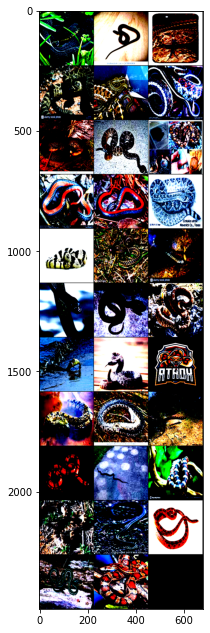

labels: tensor([15, 17,  6,  7, 31, 30, 15,  5, 10, 29, 29,  3, 11, 30, 16, 24, 28,  5,
        18,  7,  3, 17, 10, 18, 12,  2, 11, 21, 32, 22, 32, 22])


In [14]:
train_loader,test_loader,val_loader = transformDS1(32,224)
show_transformed_images(val_loader)

In [ ]:
def train(num_epochs, train_loader, criterion, optimizer):
  Accuracies = [] 
  valAccuracies = []
  valLoss = []
  trainLoss = []
  total_steps = len(train_loader)
  t1 = time.time()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  validation_accuracy = 0
  epoch_count = 0
  for epoch in range(num_epochs):
      print("Epoch number %d" %(epoch+1))
      resnet18Model.train()
      running_loss = 0.0
      running_correct = 0.0
      val_loss = 0.0
      total = 0
      for i, data in enumerate(train_loader):
        images,labels = data
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images = images.to(device)
        labels = labels.to(device)
        total+=labels.size(0)

        optimizer.zero_grad()
        outputs = resnet18Model(images)
        _,predicted = torch.max(outputs.data,1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
              
        running_loss+=loss.item()
        running_correct += (labels==predicted).sum().item()
      
        
        training_accuracy = (running_correct / total) * 100
      validation_accuracy = 0
      resnet18Model.eval()
      with torch.no_grad(): 
          val_correct = 0
          val_total = 0
          val_loss = 0
          for data in val_loader:
              images, val_labels = data[0].to(device), data[1].to(device)
              images = images.to(device)
              val_labels = val_labels.to(device)
              outputs = resnet18Model(images)
              lossVal = criterion(outputs,val_labels)
              val_loss += lossVal.item()
              # Validation set accuracy
              
              _,predicted = torch.max(outputs.data, 1)
              val_correct += (predicted == val_labels).sum().item()
              val_total  += val_labels.size(0)
            
          validation_accuracy = (val_correct / val_total) *100

      scheduler.step()  
      epoch_loss = running_loss/len(train_loader)
      val_loss = val_loss/len(val_loader)
      epoch_accuracy = 100.00 * running_correct/total
      Accuracies.append(epoch_accuracy)
      valAccuracies.append(validation_accuracy)
      trainLoss.append(epoch_loss)
      valLoss.append(val_loss)
      
      print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f"%(epoch_loss,epoch_accuracy,val_loss))

  print("---Training finished in {} seconds---".format(time.time()-t1))
  epoch_count+=num_epochs
  torch.save(resnet18Model.state_dict(), "/content/35-Class-"+str(epoch_count)+"-epoch.pt")

  test_acc = evaluate_model(resnet18Model,test_loader)
  return trainLoss,Accuracies

In [ ]:
import random
hyper_parameters = [0.01,0.001,0.0001,0.2,0.002,0.002,0.1,0.3,0.003,0.03,0.0003,]
train_lr_picked = random.sample(hyper_parameters, 3)
train_loss_hyper_parameters = []
train_acc_hyper_parameters = []
batch_size = 32
num_epochs = 20


for learning_rate in train_lr_picked:
    print(f'Results of the learning rate = {learning_rate}')
    resnet18Model=models.resnet18(pretrained=False)
    num_filters = resnet18Model.fc.in_features
    num_classes = 35 
    resnet18Model.fc = nn.Linear(num_filters,num_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    resnet18Model.to(device)
    optimizer = torch.optim.SGD(resnet18Model.parameters(), lr=learning_rate,momentum=0.9)
    loss,accuracy = train(num_epochs,train_loader,criterion,optimizer)
    train_loss_hyper_parameters.append(loss)
    train_acc_hyper_parameters.append(accuracy)

Results of the learning rate = 0.01
Epoch number 1


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training Data: Epoch Loss: 3.519, Epoch Accuracy: 7.791, Validation Loss: 3.363
Epoch number 2
Training Data: Epoch Loss: 3.236, Epoch Accuracy: 12.804, Validation Loss: 3.162
Epoch number 3
Training Data: Epoch Loss: 3.087, Epoch Accuracy: 16.048, Validation Loss: 3.088
Epoch number 4
Training Data: Epoch Loss: 2.940, Epoch Accuracy: 19.434, Validation Loss: 2.928
Epoch number 5
Training Data: Epoch Loss: 2.794, Epoch Accuracy: 23.058, Validation Loss: 2.772
Epoch number 6
Training Data: Epoch Loss: 2.654, Epoch Accuracy: 25.618, Validation Loss: 2.647
Epoch number 7
Training Data: Epoch Loss: 2.539, Epoch Accuracy: 28.016, Validation Loss: 2.843
Epoch number 8
Training Data: Epoch Loss: 2.403, Epoch Accuracy: 31.662, Validation Loss: 2.490
Epoch number 9
Training Data: Epoch Loss: 2.278, Epoch Accuracy: 34.950, Validation Loss: 2.558
Epoch number 10
Training Data: Epoch Loss: 2.156, Epoch Accuracy: 37.923, Validation Loss: 2.300
Epoch number 11
Training Data: Epoch Loss: 2.045, Epoch

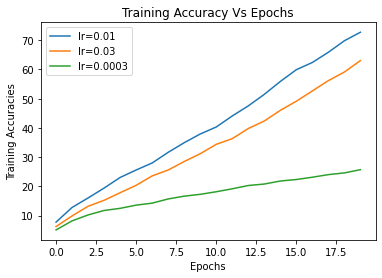

In [ ]:
train_acc_lr1 = [7.791,12.804,16.048,19.434,23.058, 25.618, 28.016, 31.662, 34.950, 37.923, 40.321, 44.097,  47.537, 51.487, 55.892, 59.918, 62.391, 65.885,  69.824, 72.732]
train_acc_lr2 = [6.261,9.907,13.205,15.256,17.839,20.378,23.600,25.608, 28.516,31.174, 34.397,  36.328,39.800, 42.372, 46.018,49.132, 52.658,  56.185,59.125, 63.032]
train_acc_lr3 = [5.122,8.214,10.243,11.773, 12.500,13.596,14.280, 15.712,16.667,17.296,18.175, 19.184, 20.312,20.812, 21.842,22.363,23.145, 24.034,24.620,25.727]
# Plotting Accuracies Vs Epochs
plt.plot(range(20),train_acc_lr1, label = "lr=0.01")
plt.plot(range(20),train_acc_lr2,label = "lr=0.03")
plt.plot(range(20),train_acc_lr3,label = "lr=0.0003")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.legend()
plt.show()

In [ ]:
import random
hyper_parameters = [16,32,64,128,256]
train_batch_picked = random.sample(hyper_parameters, 3)
train_loss_hyper_parameters_batch = []
train_acc_hyper_parameters_batch = []
num_epochs = 20


for batch_size in train_batch_picked:
    print(f'Results of the learning rate = {batch_size}')
    train_loader,test_loader,val_loader = transformDS1(batch_size,224)
    resnet18Model=models.resnet18(pretrained=False)
    num_filters = resnet18Model.fc.in_features
    num_classes = 35 
    resnet18Model.fc = nn.Linear(num_filters,num_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    resnet18Model.to(device)
    optimizer = torch.optim.SGD(resnet18Model.parameters(), lr=0.01,momentum=0.9)
    loss,accuracy = train(num_epochs,train_loader,criterion,optimizer)
    train_loss_hyper_parameters_batch.append(loss)
    train_acc_hyper_parameters_batch.append(accuracy)

Results of the learning rate = 16
Epoch number 1


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training Data: Epoch Loss: 3.613, Epoch Accuracy: 5.914, Validation Loss: 3.511
Epoch number 2
Training Data: Epoch Loss: 3.346, Epoch Accuracy: 9.983, Validation Loss: 3.328
Epoch number 3
Training Data: Epoch Loss: 3.225, Epoch Accuracy: 12.153, Validation Loss: 3.166
Epoch number 4
Training Data: Epoch Loss: 3.112, Epoch Accuracy: 14.670, Validation Loss: 3.045
Epoch number 5
Training Data: Epoch Loss: 3.000, Epoch Accuracy: 17.274, Validation Loss: 3.096
Epoch number 6
Training Data: Epoch Loss: 2.875, Epoch Accuracy: 20.041, Validation Loss: 2.932
Epoch number 7
Training Data: Epoch Loss: 2.766, Epoch Accuracy: 22.797, Validation Loss: 2.796
Epoch number 8
Training Data: Epoch Loss: 2.648, Epoch Accuracy: 25.477, Validation Loss: 2.662
Epoch number 9
Training Data: Epoch Loss: 2.530, Epoch Accuracy: 28.494, Validation Loss: 2.563
Epoch number 10
Training Data: Epoch Loss: 2.419, Epoch Accuracy: 31.261, Validation Loss: 2.645
Epoch number 11
Training Data: Epoch Loss: 2.322, Epoch 

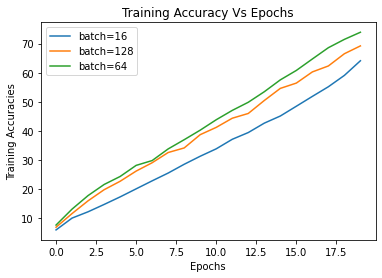

In [ ]:
# Plotting Accuracies Vs Epochs
plt.plot(range(20),train_acc_hyper_parameters_batch[0], label = "batch=16")
plt.plot(range(20),train_acc_hyper_parameters_batch[1],label = "batch=128")
plt.plot(range(20),train_acc_hyper_parameters_batch[2],label = "batch=64")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.legend()
plt.show()

In [15]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [16]:
early_stopper = EarlyStopper(patience=3, min_delta=10)

In [18]:
train_loader,test_loader,val_loader = transformDS1(64,224)
resnet18Model=models.resnet18(pretrained=False)
num_filters = resnet18Model.fc.in_features
num_classes = 35 
resnet18Model.fc = nn.Linear(num_filters,num_classes)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(resnet18Model)
# summary(resnet18Model,input_size=(3,324,324))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18Model.to(device)
print("Device: {}".format(device))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18Model.parameters(), lr=0.01,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001)
n_epochs = 100

epoch_count = 0

Accuracies = [] 
valAccuracies = []
valLoss = []
trainLoss = []
total_steps = len(train_loader)
t1 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
validation_accuracy = 0

for epoch in range(n_epochs):
    print("Epoch number %d" %(epoch+1))
    resnet18Model.train()
    running_loss = 0.0
    running_correct = 0.0
    val_loss = 0.0
    total = 0
    for i, data in enumerate(train_loader):
      images,labels = data
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      images = images.to(device)
      labels = labels.to(device)
      total+=labels.size(0)

      optimizer.zero_grad()
      outputs = resnet18Model(images)
      _,predicted = torch.max(outputs.data,1)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      
      running_loss+=loss.item()
      running_correct += (labels==predicted).sum().item()
     
      
      training_accuracy = (running_correct / total) * 100
    validation_accuracy = 0
    resnet18Model.eval()
    with torch.no_grad(): 
        val_correct = 0
        val_total = 0
        val_loss = 0
        for data in val_loader:
            images, val_labels = data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs = resnet18Model(images)
            lossVal = criterion(outputs,val_labels)
            val_loss += lossVal.item()
            # Validation set accuracy
            
            _,predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == val_labels).sum().item()
            val_total  += val_labels.size(0)
          
        validation_accuracy = (val_correct / val_total) *100

    scheduler.step()  
    epoch_loss = running_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    epoch_accuracy = 100.00 * running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    trainLoss.append(epoch_loss)
    valLoss.append(val_loss)
    
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f"%(epoch_loss,epoch_accuracy,val_loss))
    if early_stopper.early_stop(val_loss):             
        break
print("---Training finished in {} seconds---".format(time.time()-t1))
epoch_count+=n_epochs
torch.save(resnet18Model.state_dict(), "/content/35-Class-"+str(epoch_count)+"-epoch.pt")

test_acc = evaluate_model(resnet18Model,test_loader)
dict = {'Training': Accuracies, 'Validation': valAccuracies} 
dictLoss = {'Training': trainLoss,'Validation': valLoss}
df = pd.DataFrame(dict)
df2 = pd.DataFrame(dictLoss)
df.to_csv("/content/Accuracies"+str(epoch_count)+".csv")
df2.to_csv("/content/Loss"+str(epoch_count)+".csv")
files.download("/content/35-Class-"+str(epoch_count)+"-epoch.pt")
files.download("/content/Accuracies"+str(epoch_count)+".csv")
files.download("/content/Loss"+str(epoch_count)+".csv")

Device: cuda:0
Epoch number 1
Training Data: Epoch Loss: 3.481, Epoch Accuracy: 7.693, Validation Loss: 3.554
Epoch number 2
Training Data: Epoch Loss: 3.196, Epoch Accuracy: 13.205, Validation Loss: 3.111
Epoch number 3
Training Data: Epoch Loss: 3.017, Epoch Accuracy: 17.643, Validation Loss: 3.237
Epoch number 4
Training Data: Epoch Loss: 2.889, Epoch Accuracy: 20.345, Validation Loss: 2.964
Epoch number 5
Training Data: Epoch Loss: 2.759, Epoch Accuracy: 23.969, Validation Loss: 2.859
Epoch number 6
Training Data: Epoch Loss: 2.608, Epoch Accuracy: 26.964, Validation Loss: 2.818
Epoch number 7
Training Data: Epoch Loss: 2.471, Epoch Accuracy: 30.545, Validation Loss: 2.736
Epoch number 8
Training Data: Epoch Loss: 2.328, Epoch Accuracy: 34.256, Validation Loss: 2.676
Epoch number 9
Training Data: Epoch Loss: 2.195, Epoch Accuracy: 37.153, Validation Loss: 3.374
Epoch number 10
Training Data: Epoch Loss: 2.089, Epoch Accuracy: 39.779, Validation Loss: 2.803
Epoch number 11
Training 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

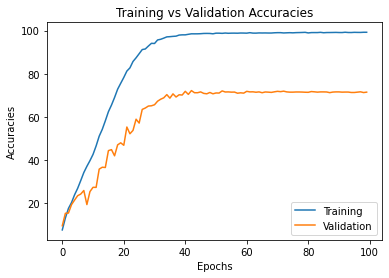

In [19]:
# Plotting Validation Accuracies Vs Train Accuracies on Epochs
plt.plot(range(n_epochs),Accuracies, label="Training")
plt.plot(range(n_epochs),valAccuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Validation Accuracies")
plt.legend()
plt.show()

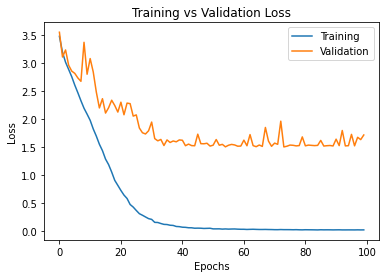

In [20]:
# Plotting Validation Accuracies Vs Train Accuracies on Epochs
plt.plot(range(n_epochs),trainLoss, label="Training")
plt.plot(range(n_epochs),valLoss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

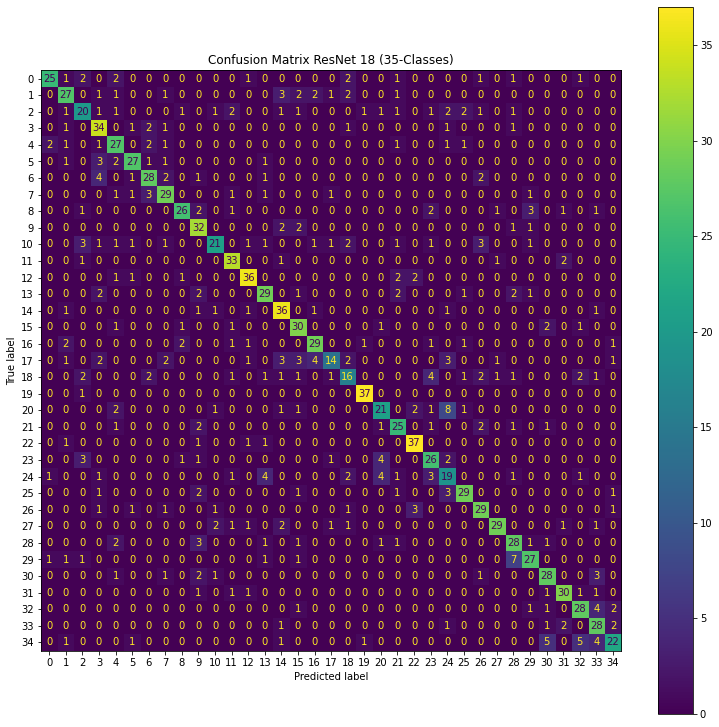

In [21]:
#Calculate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = resnet18Model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes =(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34)

# Build confusion matrix
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix ResNet 18 (35-Classes)")
disp.plot(ax=ax)
plt.show()

In [22]:
#Precision Calculation and Recall calculation
from sklearn.metrics import precision_score, recall_score,f1_score

print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Precision Macro:0.72
Precision Micro:0.72
Recall Macro:0.72
Recall Micro:0.72
F1-Score Macro:0.71
F1-Score Micro:0.72
